#### Addestramento della rete utilizzando i dataset del cromosoma 21 e 22 insieme come train/validation set

In [1]:
from fastai.tabular.all import *
from warnings import simplefilter
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
df.replace(to_replace='.', value=np.NaN, inplace=True)
df.replace(regex='^[.;]+$', value=np.NaN, inplace=True)
df.apply(pd.to_numeric, errors='ignore')
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'association'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Affects'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'other'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other,_risk_factor', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)

/tmp/ipykernel_28297/398261580.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


In [3]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [5]:
dls = to.dataloaders(bs=1024)

In [6]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=10),)

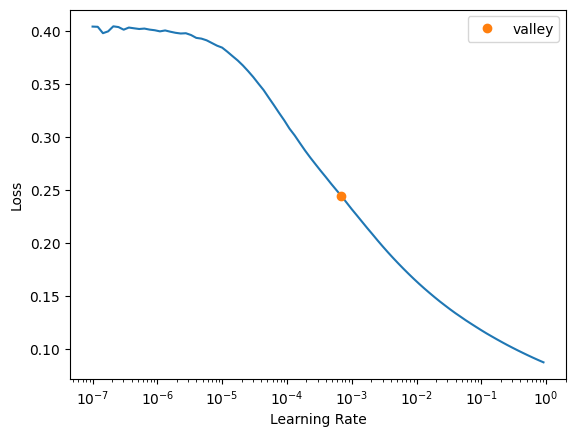

In [7]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.215992,0.136520,0.735821,00:02
1,0.144420,0.107424,0.729104,00:02
2,0.106255,0.094678,0.703731,00:02
3,0.080929,0.086762,0.723134,00:02
4,0.063054,0.079684,0.723881,00:02
5,0.050397,0.073294,0.726866,00:02
6,0.041115,0.067952,0.740299,00:02
7,0.034145,0.065336,0.758955,00:02
8,0.028740,0.066022,0.764179,00:02
9,0.024454,0.069242,0.765672,00:02


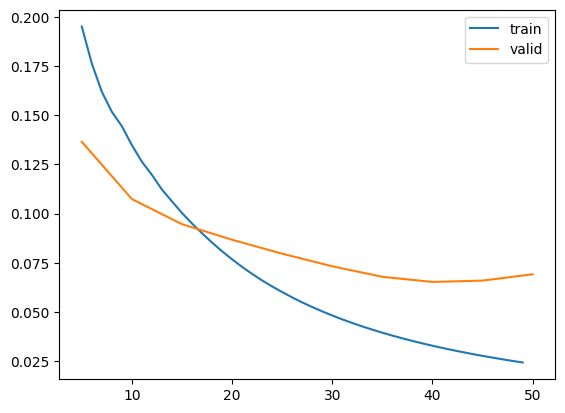

In [8]:
learn.fit(10, lr, wd=0.1)
learn.recorder.plot_loss()

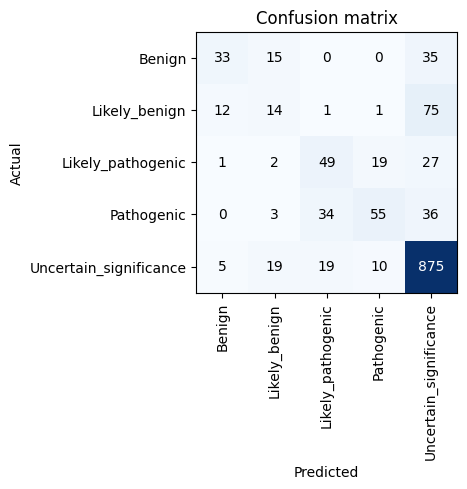

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [10]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=5360,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
     


In [11]:
xs,y = to.train.xs,to.train.y
m = rf(xs, y)

In [12]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [13]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
60,MetaRNN_rankscore,0.275662
59,MetaRNN_score,0.189180
105,clinvar_review,0.082192
78,ClinPred_score,0.052426
103,clinvar_id,0.035791
52,MetaSVM_score,0.017106
191,CADD_raw,0.014516
61,MetaRNN_pred,0.011865
56,MetaLR_rankscore,0.009535
41,MutationTaster_pred,0.009190


<Axes: ylabel='cols'>

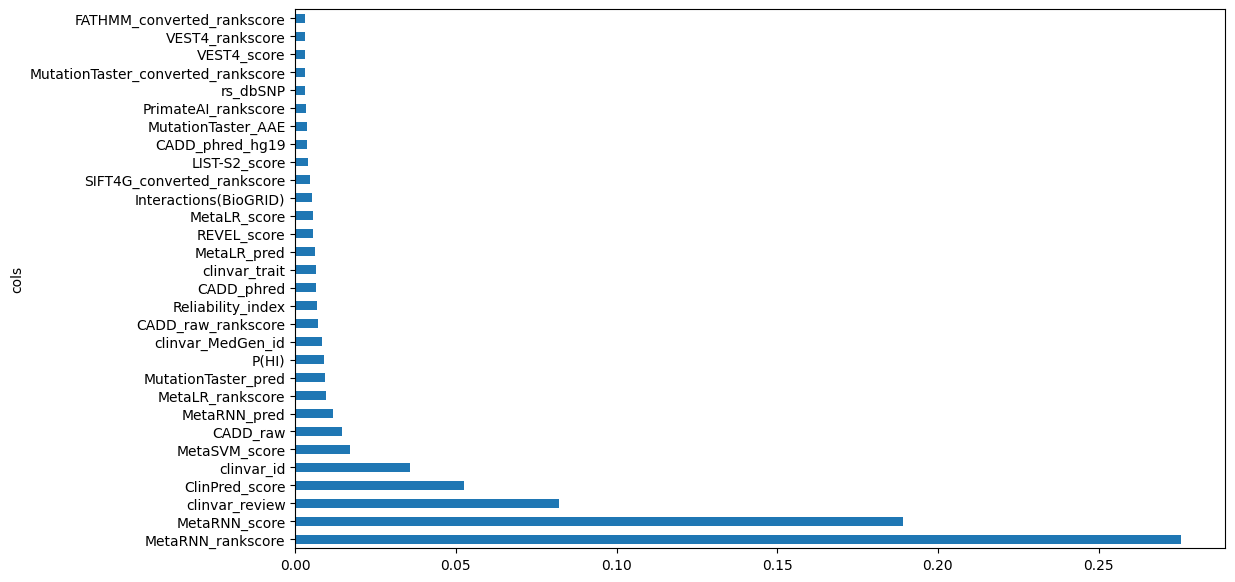

In [14]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [80]:
to_keep = fi[fi.imp>0.003].cols

In [101]:
df_keep = df[to_keep].copy()
df_keep
df_keep.drop(columns=['MetaRNN_rankscore', 'MetaRNN_score', 'clinvar_review', 'ClinPred_score'], inplace=True)

In [103]:
num_cols = df_keep.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_keep.select_dtypes(include=[object]).columns.tolist()
df = pd.concat([df['clinvar_clnsig'], df_keep], axis=1)
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df['clinvar_clnsig'].value_counts()

clinvar_clnsig
Uncertain_significance    4486
Pathogenic                 746
Likely_pathogenic          529
Likely_benign              474
Benign                     465
Name: count, dtype: int64

In [104]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [105]:
dls = to.dataloaders(bs=1024)

In [106]:
dls.show_batch()

,clinvar_id,MetaSVM_score,MetaRNN_pred,MetaLR_rankscore,MutationTaster_pred,P(HI),clinvar_MedGen_id,Reliability_index,clinvar_trait,MetaLR_pred,REVEL_score,MetaLR_score,Interactions(BioGRID),SIFT4G_converted_rankscore,LIST-S2_score,MutationTaster_AAE,PrimateAI_rankscore,rs_dbSNP,VEST4_score,VEST4_rankscore,FATHMM_converted_rankscore,aapos,ClinPred_pred,CADD_raw,CADD_raw_rankscore,CADD_phred,CADD_phred_hg19,MutationTaster_converted_rankscore,clinvar_clnsig
0,578665,-0.9876,T;T;T;T;T;T,0.38044,D;D;D;D;D,0.08067,C1837229,10,"Congenital_muscular_dystrophy-dystroglycanopathy_with_mental_retardation,_type_B6",T,0.161,0.1034,6,0.92824,.;0.90421;0.90421;0.905309;0.905309;0.905309,G96D;G96D;G96D;G96D;G96D,0.50361,rs1569341949,0.51;0.52;0.604;.;.;.,0.62188,0.47130,96;96;96;96;96;96,T,2.201901,0.34752,20.900000,22.400000,0.54805,Uncertain_significance
1,790229,-1.0081,T;T;T;T;T;T;T,0.32642,N;N;N;N;N;N,0.13725,CN517202,9,not_provided,T,0.187,0.0832,34,0.07059,.;0.840516;.;.;0.858514;0.864914;0.869413,I141V;I141V;I141V;I91V;I141V;I91V,0.29197,rs150437940,0.095;0.094;0.095;0.095;.;0.095;0.084,0.07535,0.72348,141;141;141;141;141;141;91,T,-0.478436,0.01632,0.132001,0.170001,0.18198,Likely_benign
2,962122,-0.9918,T;T;T,0.10464,N;N;N;N;N,0.20389,C0410189,10,Emery-Dreifuss_muscular_dystrophy,T,0.021,0.0245,50,0.01155,.;0.654235;0.654235,R379Q;R400Q;R379Q;R368Q;R379Q,0.01207,rs763323157,0.052;0.075;0.047,0.04913,0.27822,379;400;379,T,0.986571,0.14872,11.450000,16.110001,0.24046,Uncertain_significance
3,377288,-0.5522,T;T;T,0.54869,N;N;N,0.03165,CN517202,9,not_provided,T,0.420,0.1948,20,0.66756,0.765423;0.765423;0.864914,R138W;R139W;R98W,0.06366,rs112218090,0.473;0.485;.,0.51940,0.77843,138;139;178,T,4.345014,0.89176,29.899999,29.500000,0.23977,Benign
4,928475,#na#,#na#,#na#,D;D;D;D;D;D;D,0.15293,C0023522,#na#,Metachromatic_leukodystrophy,#na#,#na#,#na#,21,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,-1;-1;-1;-1;-1,#na#,5.058653,0.93392,33.000000,33.000000,0.81001,Likely_pathogenic
5,567616,-1.0890,T;T,0.16333,D;D,0.41624,C4225243,10,"Charcot-Marie-Tooth_disease,_axonal,_type_2z",T,0.102,0.0379,13,0.62352,0.969203;0.972903,A490T;A428T,0.69557,rs1569192031,0.335;0.335,0.37613,0.13795,490;428,D,2.719471,0.46015,22.900000,22.600000,0.58761,Uncertain_significance
6,717415,-1.1040,T,0.23602,D,0.21222,CN517202,10,not_provided,T,0.156,0.0560,77,0.27855,0.660434,C12F,0.85424,rs201522786,0.538,0.56576,0.43672,12,T,2.676685,0.45098,22.799999,23.000000,0.36992,Benign
7,230234,-0.7647,T;T;T;T;T;T;T;T;T;T;T;T,0.42036,D;D;D;D;D;D;D;D;D;D;D,0.98514,C0027672|C0346153,10,Hereditary_cancer-predisposing_syndrome|Familial_cancer_of_breast,T,0.082,0.1206,114,0.35082,.;0.943706;.;0.952605;.;0.935506;0.935506;0.957604;.;0.90231;0.862114;0.944206,N281T;N281T;N281T;N324T;N190T;N281T;N281T;N190T;N60T;N281T;.,0.48889,rs587782196,0.409;0.433;0.365;.;0.369;0.405;.;0.392;0.435;.;.;.,0.47395,0.52416,281;281;281;60;281;324;281;190;281;214;61;60,D,2.580531,0.43005,22.600000,21.799999,0.81001,Uncertain_significance
8,233376,0.4237,D;D;D;D;D;D;D;D;D,0.85600,D;D;D;D;D;D;D;D;D;D;D,0.98514,C0027672|C0346153|CN517202,10,Hereditary_cancer-predisposing_syndrome|Familial_cancer_of_breast|not_provided,D,0.793,0.5963,114,0.92824,.;0.926207;.;0.966003;.;0.963704;0.964504;0.966003;.,P426H;P426H;P426H;P469H;P335H;P397H;P397H;P335H;P205H;.;.,0.49916,rs769933461,0.907;0.883;0.923;.;0.923;0.907;.;0.91;0.882,0.92667,0.62918,426;397;426;205;426;469;426;335;397,D,4.255201,0.87088,29.200001,31.000000,0.81001,Uncertain_significance
9,627297,0.7193,D,0.93205,D,0.16068,C2751260,10,Macrothrombocytopenia,D,0.836,0.7993,33,0.92824,0.378362,W103R,#na#,rs1464643023,0.706,0.70966,0.91249,103,D,4.461700,0.90870,32.000000,31.000000,0.45007,Uncertain_significance


In [126]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=2))

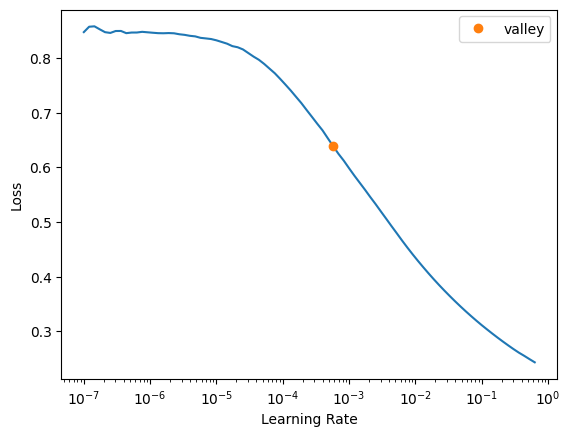

In [127]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.000284,0.419303,0.659701,00:00
1,0.000263,0.426787,0.661194,00:00
2,0.000243,0.427193,0.662687,00:00
3,0.000234,0.433531,0.662687,00:00
4,0.000223,0.434590,0.664925,00:00
5,0.000217,0.435133,0.664925,00:00
6,0.000211,0.438007,0.662687,00:00
7,0.000201,0.437119,0.664925,00:00
8,0.000195,0.439980,0.662687,00:00
9,0.000188,0.441518,0.664179,00:00


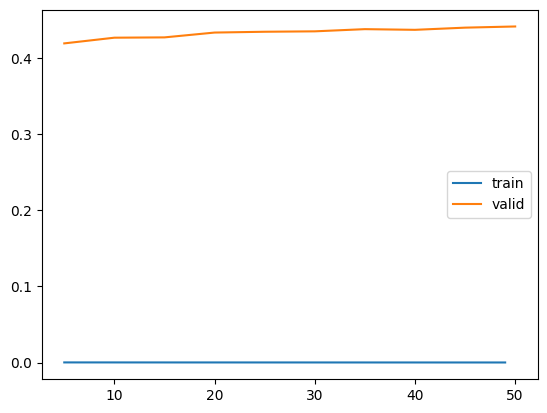

In [130]:
learn.fit(10, lr, wd=0.01)
learn.recorder.plot_loss()

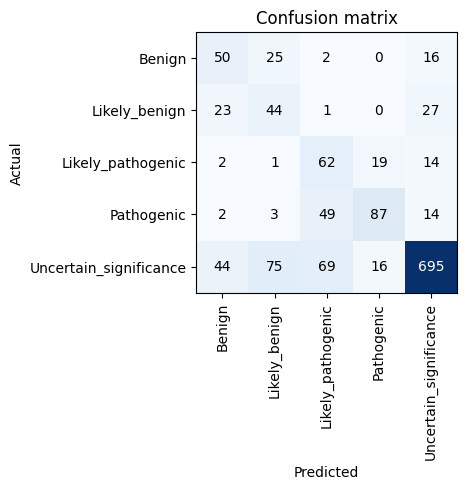

In [92]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [93]:
test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
test_df.apply(pd.to_numeric, errors='ignore')
test_df.replace(to_replace='.', value=np.nan, inplace=True)
#test_df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
#targets = test_df.pop('clinvar_clnsig')
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)



/tmp/ipykernel_738/1390448317.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


(#2) [3.302985668182373,0.21471507847309113]

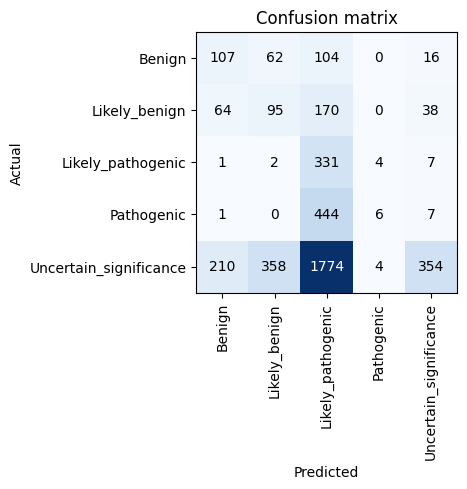

In [94]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()